In [ ]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
# === Load train dataset only === #
project = Path.cwd()
target_folder = project / "0 - data"
train_df = pd.read_excel(target_folder / "train_clean.xlsx", sheet_name="Sheet1")

In [ ]:
# === Define target + features === #
target_col = "Automation Suitable"
drop_cols = ["Task ID", "Task Name"]
drop_cols = [c for c in drop_cols if c in train_df.columns]

X_train = train_df.drop(columns=[target_col] + drop_cols)
y_train = train_df[target_col]

In [ ]:
# === Preprocessing (OneHot + passthrough) === #
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

In [ ]:
# === Build BASE model pipeline === #
rf_base_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

base_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf_base_model)
])

base_pipeline.fit(X_train,y_train)
print("✅ Random Forest BASE model trained.")

✅ Random Forest BASE model trained.



=== Top 3 for model__n_estimators (scoring=accuracy) ===
  100  ->  CV mean=0.8975 (±0.0255)
  400  ->  CV mean=0.8925 (±0.0232)
  200  ->  CV mean=0.8925 (±0.0232)


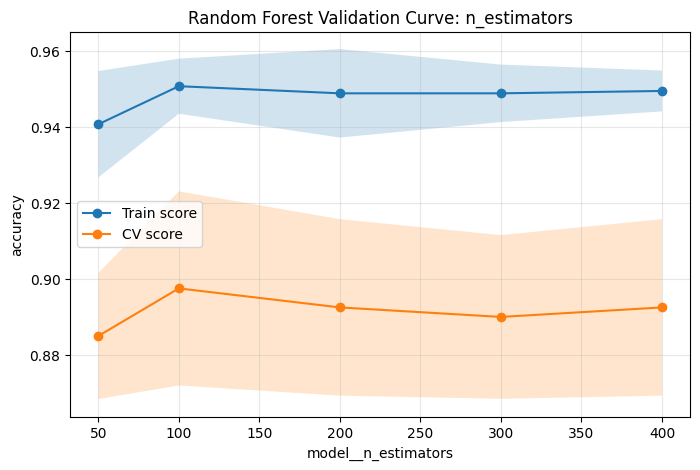


=== Top 3 for model__max_depth (scoring=accuracy) ===
  10  ->  CV mean=0.8950 (±0.0218)
  12  ->  CV mean=0.8925 (±0.0187)
  20  ->  CV mean=0.8900 (±0.0215)


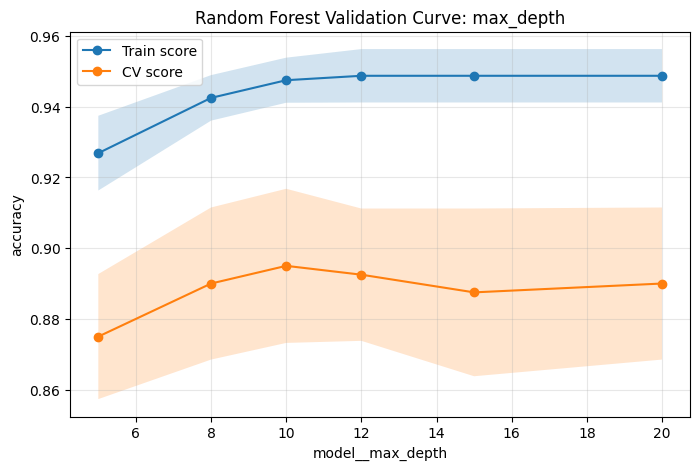


=== Top 3 for model__min_samples_leaf (scoring=accuracy) ===
  1  ->  CV mean=0.9100 (±0.0166)
  2  ->  CV mean=0.9075 (±0.0150)
  5  ->  CV mean=0.8900 (±0.0215)


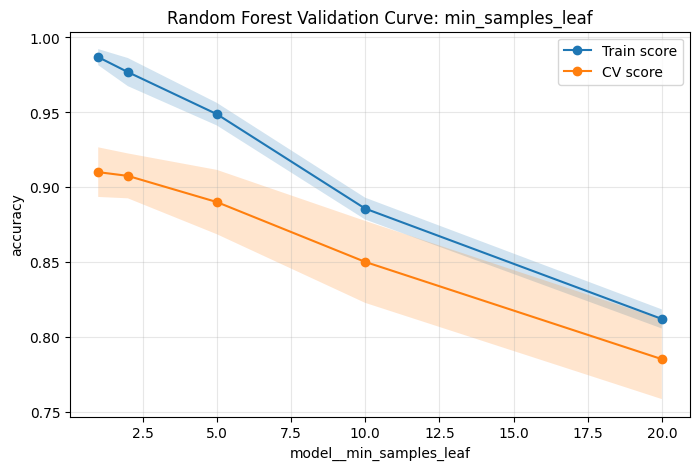

In [ ]:
# === Plot Validation Curve === #
def plot_validation_curve_top3(
    pipeline,
    X_train,
    y_train,
    param_name: str,
    param_range,
    title: str,
    scoring: str = "accuracy",
    cv: int = 5
):
    train_scores, val_scores = validation_curve(
        pipeline,
        X_train,
        y_train,
        param_name=param_name,
        param_range=param_range,
        scoring=scoring,
        cv=cv,
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    top3_idx = np.argsort(val_mean)[-3:][::-1]
    print(f"\n=== Top 3 for {param_name} (scoring={scoring}) ===")
    for i in top3_idx:
        print(f"  {param_range[i]}  ->  CV mean={val_mean[i]:.4f} (±{val_std[i]:.4f})")

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(param_range, train_mean, marker="o", label="Train score")
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2)

    plt.plot(param_range, val_mean, marker="o", label="CV score")
    plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

n_estimators_range = [50, 100, 200, 300, 400]

plot_validation_curve_top3(
    base_pipeline,
    X_train, y_train,
    param_name="model__n_estimators",
    param_range=n_estimators_range,
    title="Random Forest Validation Curve: n_estimators",
    scoring="accuracy",
    cv=5
)

max_depth_range = [5, 8, 10, 12, 15, 20]

plot_validation_curve_top3(
    base_pipeline,
    X_train, y_train,
    param_name="model__max_depth",
    param_range=max_depth_range,
    title="Random Forest Validation Curve: max_depth",
    scoring="accuracy",
    cv=5
)

min_leaf_range = [1, 2, 5, 10, 20]

plot_validation_curve_top3(
    base_pipeline,
    X_train, y_train,
    param_name="model__min_samples_leaf",
    param_range=min_leaf_range,
    title="Random Forest Validation Curve: min_samples_leaf",
    scoring="accuracy",
    cv=5
)

In [ ]:
# === Hyperparameter tuning (Random Forest) === #
param_distributions = {
    "model__n_estimators": [100, 400, 200],
    "model__max_depth": [10, 12, 20, None],
    "model__min_samples_leaf": [2, 5, 1],
}

rf_search = RandomizedSearchCV(
    estimator=base_pipeline,
    param_distributions=param_distributions,
    n_iter=15,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True
)

rf_search.fit(X_train, y_train)

print("\n✅ Random Forest tuning complete.")
print("Best CV Accuracy:", round(rf_search.best_score_, 4))
print("Best Params:", rf_search.best_params_)

tuned_pipeline = rf_search.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits

✅ Random Forest tuning complete.
Best CV Accuracy: 0.915
Best Params: {'model__n_estimators': 400, 'model__min_samples_leaf': 1, 'model__max_depth': 12}


In [ ]:
# === Save BASE + TUNED models === #
bundle = {
    "base": base_pipeline,
    "tuned": tuned_pipeline,
    "best_model": tuned_pipeline,
    "best_params": rf_search.best_params_,
    "best_cv_score": float(rf_search.best_score_),
    "meta": {
        "model_name": "Random Forest",
        "scoring": "accuracy",
        "cv_folds": 5
    }
}

save_path = "2 - models/random_forest_model.pkl"
joblib.dump(bundle, save_path)

print(f"✅ BASE + TUNED Random Forest models saved to: {save_path}")

✅ BASE + TUNED Random Forest models saved to: 2 - models/random_forest_model.pkl
